In [1]:
import pandas as pd
import colorgram as cgm
import csv
import os
from collections import Counter
import collections
import matplotlib.pyplot as plt
import numpy as np

In [2]:
K = 10 # number of nearest neightbours we are going to use

In [3]:
index=["color", "color_name", "hex", "R", "G", "B"]
colors_base = pd.read_csv('colors.csv', names=index, header=None)

In [4]:
fieldnames = ['image_name', 'color0', 'color1', 'color2', 'color3', 
              'color4', 'color5', 'color6', 'color7', 'color8', 'color9']

In [5]:
image_colors = pd.read_csv('image_colors.csv', names=fieldnames, header=None)

In [6]:
image_colors = image_colors.drop([0])

In [7]:
image_colors = image_colors.set_index("image_name")

In [8]:
human_headers = ["id", "title", "author", "type", "school", "timeframe", "description", "image_1_url",
                 "image_2_url","image_3_url", "image_4_url", "image_5_url", "image_6_url", "image_7_url",
                 "image_8_url", "image_9_url", "image_10_url", "gt"]
name_date_headers = ['name', 'date']

In [9]:
human_hard = pd.read_csv('SemArt/human_difficult.csv', names=human_headers, header=None)

In [10]:
human_easy = pd.read_csv('SemArt/human_easy.csv', names=human_headers, header=None)

In [11]:
human = pd.merge_ordered(human_hard, human_easy)

In [12]:
name_date = pd.DataFrame(columns = name_date_headers)

In [13]:
human = human.drop([200])

In [14]:
for index, row in human.iterrows():
    human_image = row['gt']
    this_image = pd.DataFrame([[row['image_{}_url'.format(human_image)], row['timeframe']]], 
                              columns=name_date_headers)
    name_date = pd.merge_ordered(name_date, this_image)

In [15]:
name_date.to_csv(path_or_buf='name_date.csv')

In [16]:
image_colors_reduced = pd.DataFrame(columns = fieldnames)

In [17]:
for name in name_date['name']:
    aux = pd.DataFrame([image_colors.loc[name]], columns = fieldnames[1:])
    aux['image_name'] = name
    image_colors_reduced = pd.merge_ordered(image_colors_reduced, aux)  

In [18]:
name_date = name_date.set_index("name")

In [19]:
def recognize_color(R,G,B):
    minimum = 10000
    for i in range(len(colors_base)):
        d = abs(R- int(colors_base.loc[i,"R"])) + abs(G- int(colors_base.loc[i,"G"]))+ abs(B- int(colors_base.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            #cname = colors_base.loc[i,"color_name"]
            chex = colors_base.loc[i, "hex"]
    return chex

In [20]:
test_image_directory = "painting/"
test_image_name = "2333.jpg"
test_image = test_image_directory+test_image_name

In [21]:
test_colors = cgm.extract(test_image, 10)
test_chexes = []
for color in test_colors:
    test_chex = recognize_color(color.rgb[0], color.rgb[1], color.rgb[2])
    test_chexes.append(test_chex)

In [22]:
columns = ['color0', 'color1', 'color2', 'color3', 'color4', 'color5', 'color6', 'color7', 'color8', 'color9']
matches = pd.DataFrame(columns = ['name', 'score'])
for index, row in image_colors_reduced.iterrows():
    first = True
    for column in columns:
        if row[column] in test_chexes:
            if first == True:
                this_image = pd.DataFrame([[row['image_name'], 1]], columns=['name', 'score'])
                matches = pd.merge_ordered(matches, this_image)
                first = False
            else:
                for i in range (0, len(matches['name'])):
                    if matches['name'][i] == row['image_name']:
                        matches['score'][i] += 1
                        break

/home/vieiragiulia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
matches = matches.sort_values(by=['score'], ascending=False)

In [24]:
nearest = matches.head(K)

In [25]:
nearest = nearest.set_index("name")

In [26]:
nearest_dates = {}
for name, value in nearest.iterrows():
    if int(name_date.loc[name]["date"][:4]) not in nearest_dates:
        nearest_dates[int(name_date.loc[name]["date"][:4])] = nearest.loc[name]["score"]
    else:
        nearest_dates[int(name_date.loc[name]["date"][:4])] += nearest.loc[name]["score"]
    if int(name_date.loc[name]["date"][5:]) not in nearest_dates:
        nearest_dates[int(name_date.loc[name]["date"][5:])] =  nearest.loc[name]["score"]
    else:
        nearest_dates[int(name_date.loc[name]["date"][5:])] +=  nearest.loc[name]["score"]

In [27]:
distribution = Counter(nearest_dates)

In [28]:
distribution = {k: v for k, v in sorted(distribution.items(), key=lambda item: item[1], reverse=True)}

In [29]:
ordered_distribution = collections.OrderedDict(sorted(distribution.items()))

In [35]:
bars = list(ordered_distribution.values())

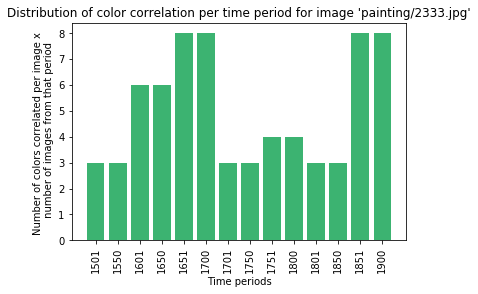

In [39]:
plt.bar(np.arange(len(bars)), bars, color='mediumseagreen')
plt.xticks(np.arange(len(bars)), list(ordered_distribution.keys()), rotation=90)
plt.xlabel("Time periods")
plt.ylabel("Number of colors correlated per image x \n number of images from that period")
plt.title("Distribution of color correlation per time period for image '{}'".format(test_image))
plt.savefig('TimeCorrelationDistribution_{}'.format(test_image_name), bbox_inches='tight', transparent=True)
plt.show()
plt.close()

#### Operation used to create image_colors.csv

In [ ]:
with open('image_colors.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    directory = 'SemArt/Images/'
    for filename in os.listdir(directory):
        if filename in image_colors["image_name"]:
            continue
        colors = cgm.extract(directory+filename, 10)
        chexes = []
        for color in colors:
            chex = recognize_color(color.rgb[0], color.rgb[1], color.rgb[2])
            chexes.append(chex)
        if len(chexes) == 10:
            writer.writerow({'image_name': filename, 'color0': chexes[0], 'color1': chexes[1], 'color2': chexes[2],
                            'color3': chexes[3], 'color4': chexes[4], 'color5': chexes[5], 'color6': chexes[6],
                            'color7': chexes[7], 'color8': chexes[8], 'color9': chexes[9]})